# Total Variation In-Painting in CVXPY
This notebook solves the *Total Variation In-Painting* problem for images. 
<center>
<img width="360" src="data/loki512_corrupted.png"/>
</center>

## Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the *$\ell_2$ total
variation*, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

Thus the problem may be expressed as
\begin{align}
\text{minimize } & \mathop{\bf tv}(U) \\
\text{subject to } & K \odot U = K \odot U^{\textrm{corr}} \\
& U \in {\bf R}^{m \times n}
\end{align}
where $U^{\textrm{corr}}$ is the corrupted image, $K_{ij} = 1$ if $(i,j) \in \mathcal{K}$ and 0 otherwise, and $\odot$ denotes the element-wise matrix product. 
This is a problem with affine constraints and a convex objective. 

We load the original image and the corrupted image and construct the `known` matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormaps

In [3]:
# Load the images
u_orig = plt.imread("data/loki512.png")
u_corr = plt.imread("data/loki512_corrupted.png")
rows, cols = u_orig.shape

In [4]:
# Construct the 'known' matrix
# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if u_orig[i, j] == u_corr[i, j]:
            known[i, j] = 1

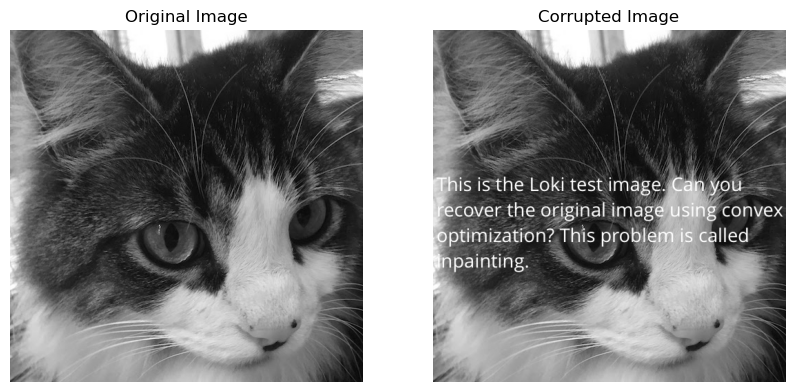

In [5]:
# Draw the original and corrupted images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

The total variation in-painting problem can be easily expressed in CVXPY. We use the solver SCS.

In [1]:
def TV_inpainting(known):
    # Recover the original image using total variation in-painting.
    U = cp.Variable(shape=(rows, cols))
    obj = cp.Minimize(cp.tv(U))
    constraints = [cp.multiply(known, U) == cp.multiply(known, u_corr)]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=True, max_iters=500) # Use SCS solver to solve the problem.
    print("optimal objective value: {}".format(obj.value))
    return U, prob

In [6]:
U, prob = TV_inpainting(known)

(CVXPY) Jan 09 01:40:26 PM: Your problem has 262144 variables, 262144 constraints, and 0 parameters.
(CVXPY) Jan 09 01:40:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 09 01:40:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 09 01:40:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 09 01:40:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 09 01:40:26 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 09 01:40:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 09 01:40:26 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 09 01:40:26 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 09 01:40:26 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.7.5                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jan 09 01:40:27 PM: Applying reduction SCS
(CVXPY) Jan 09 01:40:28 PM: Finished problem compilation (took 1.356e+00 seconds).
(CVXPY) Jan 09 01:40:28 PM: Invoking solver SCS  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.9 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 523265, constraints m: 1045507
cones: 	  z: primal zero / dual free vars: 262144
	  q: soc vars: 783363, qsize: 261121
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 500, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 1554199, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   

D:\Programmi\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jan 09 01:41:16 PM: Problem status: optimal_inaccurate
(CVXPY) Jan 09 01:41:16 PM: Optimal value: 1.105e+04
(CVXPY) Jan 09 01:41:16 PM: Compilation took 1.356e+00 seconds
(CVXPY) Jan 09 01:41:16 PM: Solver (including time spent in interface) took 4.815e+01 seconds


   500| 1.11e-02  2.49e-03  5.55e-04  1.10e+04  3.17e-01  4.80e+01 
------------------------------------------------------------------
status:  solved (inaccurate - reached max_iters)
timings: total: 4.80e+01s = setup: 3.25e+00s + solve: 4.48e+01s
	 lin-sys: 3.05e+01s, cones: 5.06e+00s, accel: 1.79e+00s
------------------------------------------------------------------
objective = 10997.777738 (inaccurate)
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
optimal objective value: 11048.480327776648


After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.

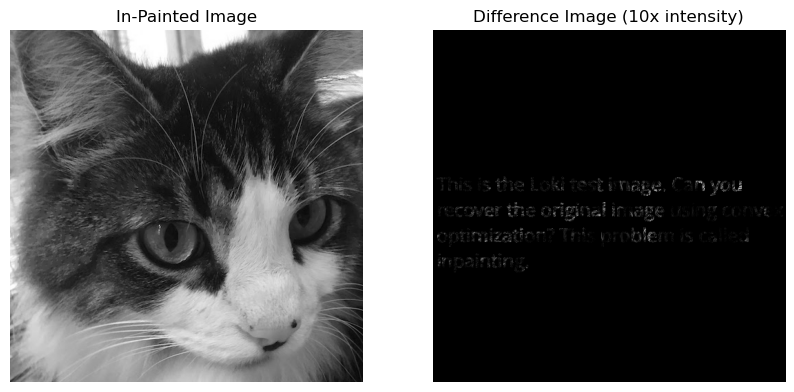

In [7]:
# Display the in-painted image and the difference image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(U.value, cmap='gray');
ax[0].set_title("In-Painted Image")
ax[0].axis('off')
img_diff = 10 * np.abs(u_orig - U.value)
ax[1].imshow(img_diff, cmap='gray');
ax[1].set_title("Difference Image (10x intensity)")
ax[1].axis('off');

# Color Images

For color images, the in-painting problem is similar to the grayscale case. A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.

In [8]:
#np.random.seed(1)
# Load the images
u_orig = plt.imread("data/loki512color.png")
rows, cols, colors = u_orig.shape

In [9]:
# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The known matrix is initialized randomly.
known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                known[i, j, k] = 1        
u_corr = known * u_orig

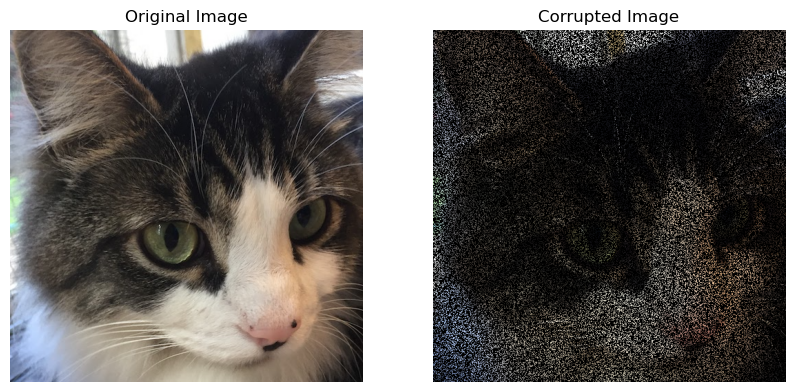

In [10]:
# Display the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). We use the solver SCS; the default solvers don't scale to this large problem.

In [14]:
def TV_inpainting_color(known): 
    # Recover the original image using total variation in-painting.
    variables = []
    constraints = []
    for i in range(colors):
        U = cp.Variable(shape=(rows, cols))
        variables.append(U)
        constraints.append(cp.multiply(known[:, :, i], U) == cp.multiply(known[:, :, i], u_corr[:, :, i]))
    
    prob = cp.Problem(cp.Minimize(cp.tv(*variables)), constraints)
    prob.solve(verbose=True, solver=cp.SCS, max_iters=500) # limit to 500 iterations to contain the time
    print("optimal objective value: {}".format(prob.value))
    return variables, prob

In [15]:
variables, prob = TV_inpainting_color(known)

(CVXPY) Jan 09 01:46:26 PM: Your problem has 786432 variables, 786432 constraints, and 0 parameters.
(CVXPY) Jan 09 01:46:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 09 01:46:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 09 01:46:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 09 01:46:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 09 01:46:26 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 09 01:46:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 09 01:46:26 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 09 01:46:26 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 09 01:46:26 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.7.5                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jan 09 01:46:27 PM: Applying reduction SCS
(CVXPY) Jan 09 01:46:28 PM: Finished problem compilation (took 2.609e+00 seconds).
(CVXPY) Jan 09 01:46:28 PM: Invoking solver SCS  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.9 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1047553, constraints m: 2614279
cones: 	  z: primal zero / dual free vars: 786432
	  q: soc vars: 1827847, qsize: 261121
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 500, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 3629686, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap 

(CVXPY) Jan 09 01:48:27 PM: Problem status: optimal_inaccurate
(CVXPY) Jan 09 01:48:27 PM: Optimal value: 1.154e+04
(CVXPY) Jan 09 01:48:27 PM: Compilation took 2.609e+00 seconds


   500| 1.13e-02  2.31e-03  1.03e-03  1.14e+04  3.17e-01  1.18e+02 
------------------------------------------------------------------
status:  solved (inaccurate - reached max_iters)
timings: total: 1.18e+02s = setup: 9.06e+00s + solve: 1.09e+02s
	 lin-sys: 7.52e+01s, cones: 1.08e+01s, accel: 4.04e+00s
------------------------------------------------------------------
objective = 11396.786713 (inaccurate)
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jan 09 01:48:27 PM: Solver (including time spent in interface) took 1.183e+02 seconds


optimal objective value: 11543.145763125101


After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

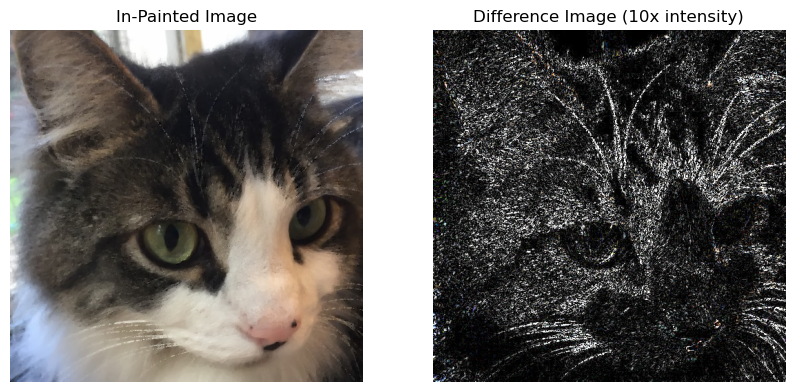

In [16]:
rec_arr = np.zeros((rows, cols, colors))
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value
rec_arr = np.clip(rec_arr, 0, 1)

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(rec_arr)
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = np.clip(10 * np.abs(u_orig - rec_arr), 0, 1)
ax[1].imshow(img_diff)
ax[1].set_title("Difference Image (10x intensity)")
ax[1].axis('off')

**Acknowledgment**. This notebook was taken (with minor adaptations) from CVXPY's examples. 